In [1]:
# python 3.6.8+
# https://www.leonardofilipe.com
# contact@leonardofilipe.com

# For yahoo finance
import io
import re
import requests

# The usual suspects
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

#  Fancy graphics
plt.style.use('seaborn')

# Getting Yahoo finance data
def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

# Assets under consideration
tickers = ['%5EGSPTSE','%5EGSPC','%5ESTOXX','000001.SS']

data = None
while data is None:
    try:
        data = getdata(tickers,'946684800','1552953600','1d')
    except:
         pass

data['%5EGSPC'].tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-12,2787.340088,2798.320068,2786.729980,2791.520020,2791.520020,3414230000
2019-03-13,2799.780029,2821.239990,2799.780029,2810.919922,2810.919922,3766150000
2019-03-14,2810.379883,2815.000000,2803.459961,2808.479980,2808.479980,3469730000
2019-03-15,2810.790039,2830.729980,2810.790039,2822.479980,2822.479980,5962730000
2019-03-18,2822.610107,2835.409912,2821.989990,2832.939941,2832.939941,3552190000


In [2]:
boughtSP = float(data['%5EGSPC']['Adj Close'][:1])
soldSP = data['%5EGSPC']['Adj Close']
BuyHoldSP = soldSP/boughtSP-1

boughtTSX = float(data['%5EGSPTSE']['Adj Close'][:1])
soldTSX = data['%5EGSPTSE']['Adj Close']
BuyHoldTSX = soldTSX/boughtTSX-1

boughtSTOXX = float(data['%5ESTOXX']['Adj Close'][:1])
soldSTOXX = data['%5ESTOXX']['Adj Close']
BuyHoldSTOXX = soldSTOXX/boughtSTOXX-1

boughtSSE = float(data['000001.SS']['Adj Close'][:1])
soldSSE = data['000001.SS']['Adj Close']
BuyHoldSSE = soldSSE/boughtSSE-1

BuyHoldAll = (BuyHoldSP*(1/4)+BuyHoldTSX*(1/4)+
              BuyHoldSTOXX*(1/4)+BuyHoldSSE*(1/4)).fillna(method='ffill')

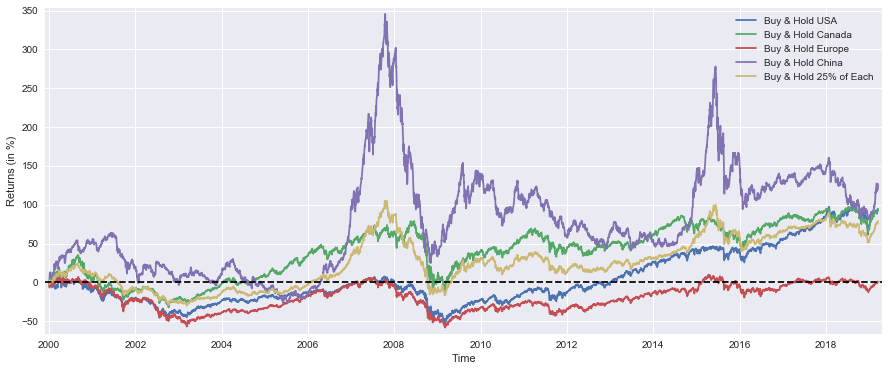

In [3]:
plt.figure(figsize=(15,6))
#=============================================================================================
plt.plot(BuyHoldSP*100, label='Buy & Hold USA')
plt.plot(BuyHoldTSX*100, label='Buy & Hold Canada')
plt.plot(BuyHoldSTOXX*100, label='Buy & Hold Europe')
plt.plot(BuyHoldSSE*100, label='Buy & Hold China')
plt.plot(BuyHoldAll*100, label='Buy & Hold 25% of Each')
# if you wish to hide a graph add # before the code of the respective graph
#=============================================================================================
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [4]:
bought1ySP = data['%5EGSPC']['Adj Close'].shift(252)
BuyHold1ySP = soldSP/bought1ySP-1

bought1yTSX = data['%5EGSPTSE']['Adj Close'].shift(252)
BuyHold1yTSX = soldTSX/bought1yTSX-1

bought1ySTOXX = data['%5ESTOXX']['Adj Close'].shift(252)
BuyHold1ySTOXX = soldSTOXX/bought1ySTOXX-1

bought1ySSE = data['000001.SS']['Adj Close'].shift(252)
BuyHold1ySSE = soldSSE/bought1ySSE-1

BuyHold1yAll = (BuyHold1ySP*(1/4)+BuyHold1yTSX*(1/4)+
                BuyHold1ySTOXX*(1/4)+BuyHold1ySSE*(1/4)).fillna(method='ffill')

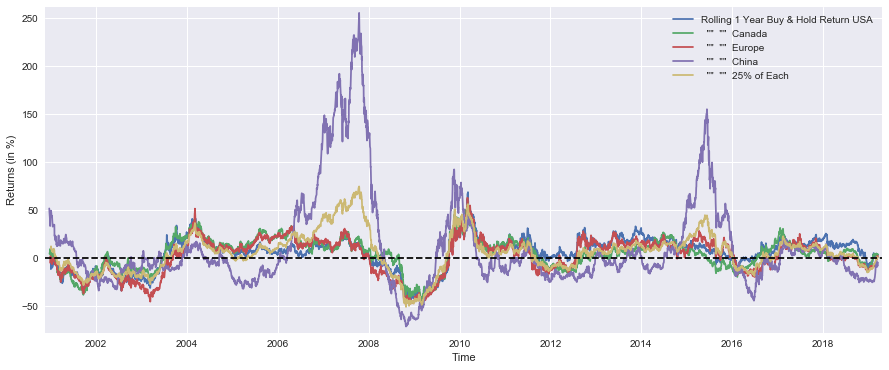

In [5]:
plt.figure(figsize=(15,6))
#=============================================================================================
plt.plot(BuyHold1ySP*100, label='Rolling 1 Year Buy & Hold Return USA')
plt.plot(BuyHold1yTSX*100, label='  ""  ""  Canada')
plt.plot(BuyHold1ySTOXX*100, label='  ""  ""  Europe')
plt.plot(BuyHold1ySSE*100, label='  ""  ""  China')
plt.plot(BuyHold1yAll*100, label='  ""  ""  25% of Each')
# if you wish to hide a graph add # before the code of the respective graph
#=============================================================================================
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [6]:
marr = 0 #minimal acceptable rate of return (communally equall to the risk free rate)
SP1YS = (BuyHold1ySP.mean()-marr)/BuyHold1ySP.std()
TSX1YS = (BuyHold1yTSX.mean()-marr)/BuyHold1yTSX.std()
STOXX1YS = (BuyHold1ySTOXX.mean()-marr)/BuyHold1ySTOXX.std()
SSE1YS = (BuyHold1ySSE.mean()-marr)/BuyHold1ySSE.std()
All1YS = (BuyHold1yAll.mean()-marr)/BuyHold1yAll.std()

print('SP500 1 Year Buy & Hold Sharpe Ratio =',round(SP1YS,2))
print('TSX "" "" =',round(TSX1YS,2))
print('STOXX600 "" "" =',round(STOXX1YS,2))
print('SSE "" "" =',round(SSE1YS,2))
print('25% of Each "" "" =',round(All1YS,2))

SP500 1 Year Buy & Hold Sharpe Ratio = 0.31
TSX "" "" = 0.25
STOXX600 "" "" = 0.1
SSE "" "" = 0.21
25% of Each "" "" = 0.26


In [7]:
SP1YD = (BuyHold1ySP.mean()-marr)/BuyHold1ySP[BuyHold1ySP < 0].std()
TSX1YD = (BuyHold1yTSX.mean()-marr)/BuyHold1yTSX[BuyHold1yTSX < 0].std()
STOXX1YD = (BuyHold1ySTOXX.mean()-marr)/BuyHold1ySTOXX[BuyHold1ySTOXX < 0].std()
SSE1YD = (BuyHold1ySSE.mean()-marr)/BuyHold1ySSE[BuyHold1ySSE < 0].std()
All1YD = (BuyHold1yAll.mean()-marr)/BuyHold1yAll[BuyHold1yAll < 0].std()

print('SP500 1 Year Buy & Hold Sortino Ratio =',round(SP1YD,2))
print('TSX "" "" =',round(TSX1YD,2))
print('STOXX600 "" "" =',round(STOXX1YD,2))
print('SSE "" "" =',round(SSE1YD,2))
print('25% of Each "" "" =',round(All1YD,2))

SP500 1 Year Buy & Hold Sortino Ratio = 0.44
TSX "" "" = 0.39
STOXX600 "" "" = 0.15
SSE "" "" = 0.76
25% of Each "" "" = 0.48


In [8]:
from scipy.optimize import minimize

def multi(x):
    a, b, c, d = x
    return a, b, c, d

def maximize_sharpe(x):
    weights = (BuyHold1ySP*(multi(x)[0])+BuyHold1yTSX*(multi(x)[1])+
               BuyHold1ySTOXX*(multi(x)[2])+BuyHold1ySSE*(multi(x)[3])).fillna(method='ffill')
    return -(weights.mean()/weights.std())

def constraint(x):
    return 1 - (multi(x)[0]+multi(x)[1]+multi(x)[2]+multi(x)[3])

cons = ({'type':'ineq','fun':constraint})
bnds = ((0,1),(0,1),(0,1),(0,1))
initial_guess = (0.25, 0.25, 0.25, 0.25)

opti = minimize(maximize_sharpe, initial_guess, method='SLSQP', bounds=bnds, constraints=cons)

optBuyHoldAll = (BuyHoldSP*(round(opti.x[0],2))+BuyHoldTSX*(round(opti.x[1],2))+
                 BuyHoldSTOXX*(round(opti.x[2],2))+BuyHoldSSE*(round(opti.x[3],2))).fillna(method='ffill')

optBuyHold1yAll = (BuyHold1ySP*(round(opti.x[0],2))+BuyHold1yTSX*(round(opti.x[1],2))+
                   BuyHold1ySTOXX*(round(opti.x[2],2))+BuyHold1ySSE*(round(opti.x[3],2))).fillna(method='ffill')

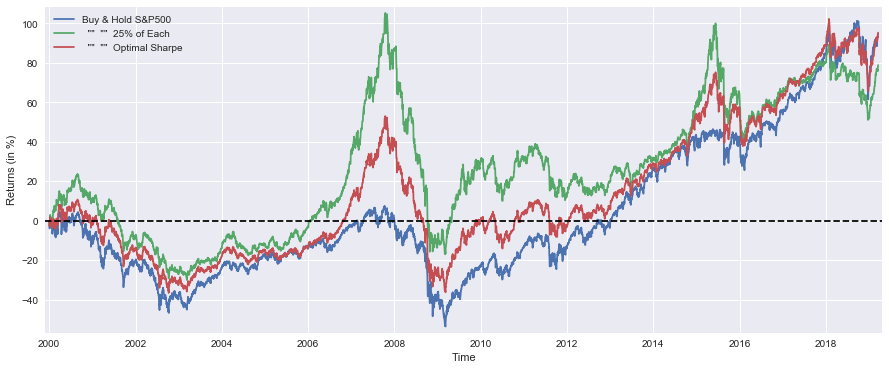

SP500 Weight = 82.0 %
TSX "" = 0.0 %
STOXX600 "" = 0.0 %
SSE "" = 14.000000000000002 %

Optimal Sharpe = 0.33

Median yearly excess return over SP500 = -0.85 %
"" "" "" "" over Equall Weights = 1.89 %


In [9]:
plt.figure(figsize=(15,6))
plt.plot(BuyHoldSP*100, label='Buy & Hold S&P500')
plt.plot(BuyHoldAll*100, label='  ""  ""  25% of Each')
plt.plot(optBuyHoldAll*100, label='  ""  ""  Optimal Sharpe')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('SP500 Weight =',round(opti.x[0],2)*100,'%')
print('TSX "" =',round(opti.x[1],2)*100,'%')
print('STOXX600 "" =',round(opti.x[2],2)*100,'%')
print('SSE "" =',round(opti.x[3],2)*100,'%')
print()
print('Optimal Sharpe =',round(optBuyHold1yAll.mean()/optBuyHold1yAll.std(),3))
print()
print('Median yearly excess return over SP500 =',round((optBuyHold1yAll.median()-BuyHold1ySP.median())*100,2),'%')
print('"" "" "" "" over Equall Weights =',round((optBuyHold1yAll.median()-BuyHold1yAll.median())*100,2),'%')

In [10]:
boughtLySP = float(data['%5EGSPC']['Adj Close'][-252])
soldLySP = data['%5EGSPC']['Adj Close'][-252:]
BuyHoldSPytd = soldLySP/boughtLySP-1

boughtLyTSX = float(data['%5EGSPTSE']['Adj Close'][-252])
soldLyTSX = data['%5EGSPTSE']['Adj Close'][-252:]
BuyHoldTSXytd = soldLyTSX/boughtLyTSX-1

boughtLySTOXX = float(data['%5ESTOXX']['Adj Close'][-252])
soldLySTOXX = data['%5ESTOXX']['Adj Close'][-252:]
BuyHoldSTOXXytd = soldLySTOXX/boughtLySTOXX-1

boughtLySSE = float(data['000001.SS']['Adj Close'][-252])
soldLySSE = data['000001.SS']['Adj Close'][-252:]
BuyHoldSSEytd = soldLySSE/boughtLySSE-1

BuyHoldAllytd = (BuyHoldSPytd*(1/4)+BuyHoldTSXytd*(1/4)+
                 BuyHoldSTOXXytd*(1/4)+BuyHoldSSEytd*(1/4)).fillna(method='ffill')

optBuyHoldAllytd = (BuyHoldSPytd*(round(opti.x[0],2))+BuyHoldTSXytd*(round(opti.x[1],2))+
                    BuyHoldSTOXXytd*(round(opti.x[2],2))+BuyHoldSSEytd*(round(opti.x[3],2))).fillna(method='ffill')

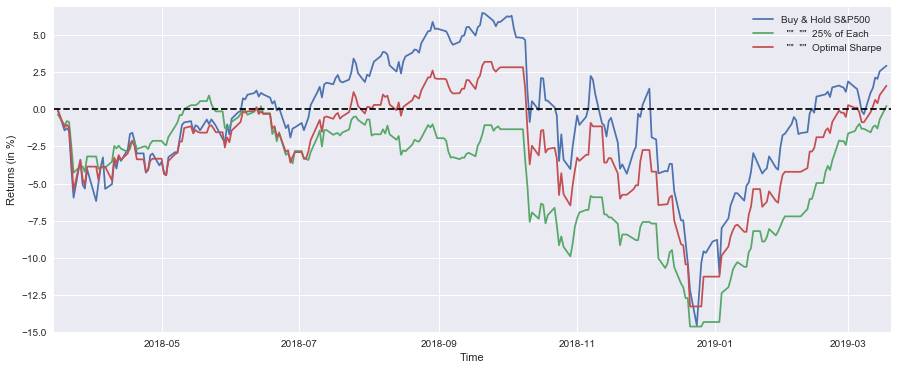

Buy & Hold S&P500 YTD Performance (at 18 March 2019) = 2.94 %
 "" "" 25% of Each "" "" = 0.22 %
 "" "" Optimal Sharpe "" "" = 1.59 %


In [11]:
plt.figure(figsize=(15,6))
plt.plot(BuyHoldSPytd*100, label='Buy & Hold S&P500')
plt.plot(BuyHoldAllytd*100, label='  ""  ""  25% of Each')
plt.plot(optBuyHoldAllytd*100, label='  ""  ""  Optimal Sharpe')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('Buy & Hold S&P500 YTD Performance (at 18 March 2019) =',round(float(BuyHoldSPytd[-1:]*100),2),'%')
print(' "" "" 25% of Each "" "" =',round(float(BuyHoldAllytd[-1:]*100),2),'%')
print(' "" "" Optimal Sharpe "" "" =',round(float(optBuyHoldAllytd[-1:]*100),2),'%')